# Scratch Detection 

In [ ]:
import zipfile
import matplotlib.pyplot as plt
import pickle
import torch.nn as nn
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data import random_split
import pickle
import torch.nn.functional as F

### Load Data

In [ ]:
#load zip file
zf = zipfile.ZipFile('data.zip') 

In [ ]:
#load train data
df_wafers = pd.read_csv(zf.open('df_wafers.csv'))
df_wafers.head()

In [ ]:
#load test data
df_wafers_test = pd.read_csv("df_wafers_test.csv")
df_wafers_test.head()

,WaferName,DieX,DieY,IsGoodDie
0,5a6ad6,0,12,False
1,5a6ad6,0,13,True
2,5a6ad6,0,14,True
3,5a6ad6,0,15,True
4,5a6ad6,0,16,True


You can draw the wafers map to see how the wafers look like in the data. 

Using the following helper function you can draw the wafer maps with or without labels:

In [ ]:
def plot_wafer_maps(wafer_df_list, figsize, labels = True):
    """
    plot wafer maps for list of df of wafers

    :param wafer_df_list: list, The list of df's of the wafers
    :param figsize: int, the size of the figsize height 
    :param labels: bool, Whether to show the layer of labels (based on column 'IsScratchDie')
    
    :return: None
    """
    def plot_wafer_map(wafer_df, ax, map_type):
        wafer_size = len(wafer_df)
        s = 2**17/(wafer_size)
        if map_type == 'Label':
            mes = 'Scratch Wafer' if (wafer_df['IsScratchDie'] == True).sum()>0 else 'Non-Scratch Wafer'
        else:
            mes = 'Yield: ' + str(round((wafer_df['IsGoodDie']).sum()/(wafer_df['IsGoodDie']).count(), 2)) 
        
        ax.set_title(f'{map_type} | Wafer Name: {wafer_df["WaferName"].iloc[0]}, \nSum: {len(wafer_df)} dies. {mes}', fontsize=20)
        ax.scatter(wafer_df['DieX'], wafer_df['DieY'], color = 'green', marker='s', s = s)

        bad_bins = wafer_df.loc[wafer_df['IsGoodDie'] == False]
        ax.scatter(bad_bins['DieX'], bad_bins['DieY'], color = 'red', marker='s', s = s)
        
        if map_type == 'Label':
            scratch_bins = wafer_df.loc[(wafer_df['IsScratchDie'] == True) & (wafer_df['IsGoodDie'] == False)]
            ax.scatter(scratch_bins['DieX'], scratch_bins['DieY'], color = 'blue', marker='s', s = s)

            ink_bins = wafer_df.loc[(wafer_df['IsScratchDie'] == True) & (wafer_df['IsGoodDie'] == True)]
            ax.scatter(ink_bins['DieX'], ink_bins['DieY'], color = 'yellow', marker='s', s = s)

            ax.legend(['Good Die', 'Bad Die', 'Scratch Die', 'Ink Die'], fontsize=8)
        else:
            ax.legend(['Good Die', 'Bad Die'], fontsize=8)

        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False) 
    
    import numpy as np
    import matplotlib.pyplot as plt
    
    if labels:
        fig, ax = plt.subplots(2, len(wafer_df_list), figsize=(figsize*len(wafer_df_list), figsize*2))
        for idx1, wafer_df in enumerate(wafer_df_list):
            for idx2, map_type in enumerate(['Input', 'Label']):
                plot_wafer_map(wafer_df, ax[idx2][idx1], map_type)
    else:
        fig, ax = plt.subplots(1, len(wafer_df_list), figsize=(figsize*len(wafer_df_list), figsize))
        for idx, wafer_df in enumerate(wafer_df_list):
            plot_wafer_map(wafer_df, ax[idx], 'Input')

    plt.show()

Select the amount of samples you want to display:

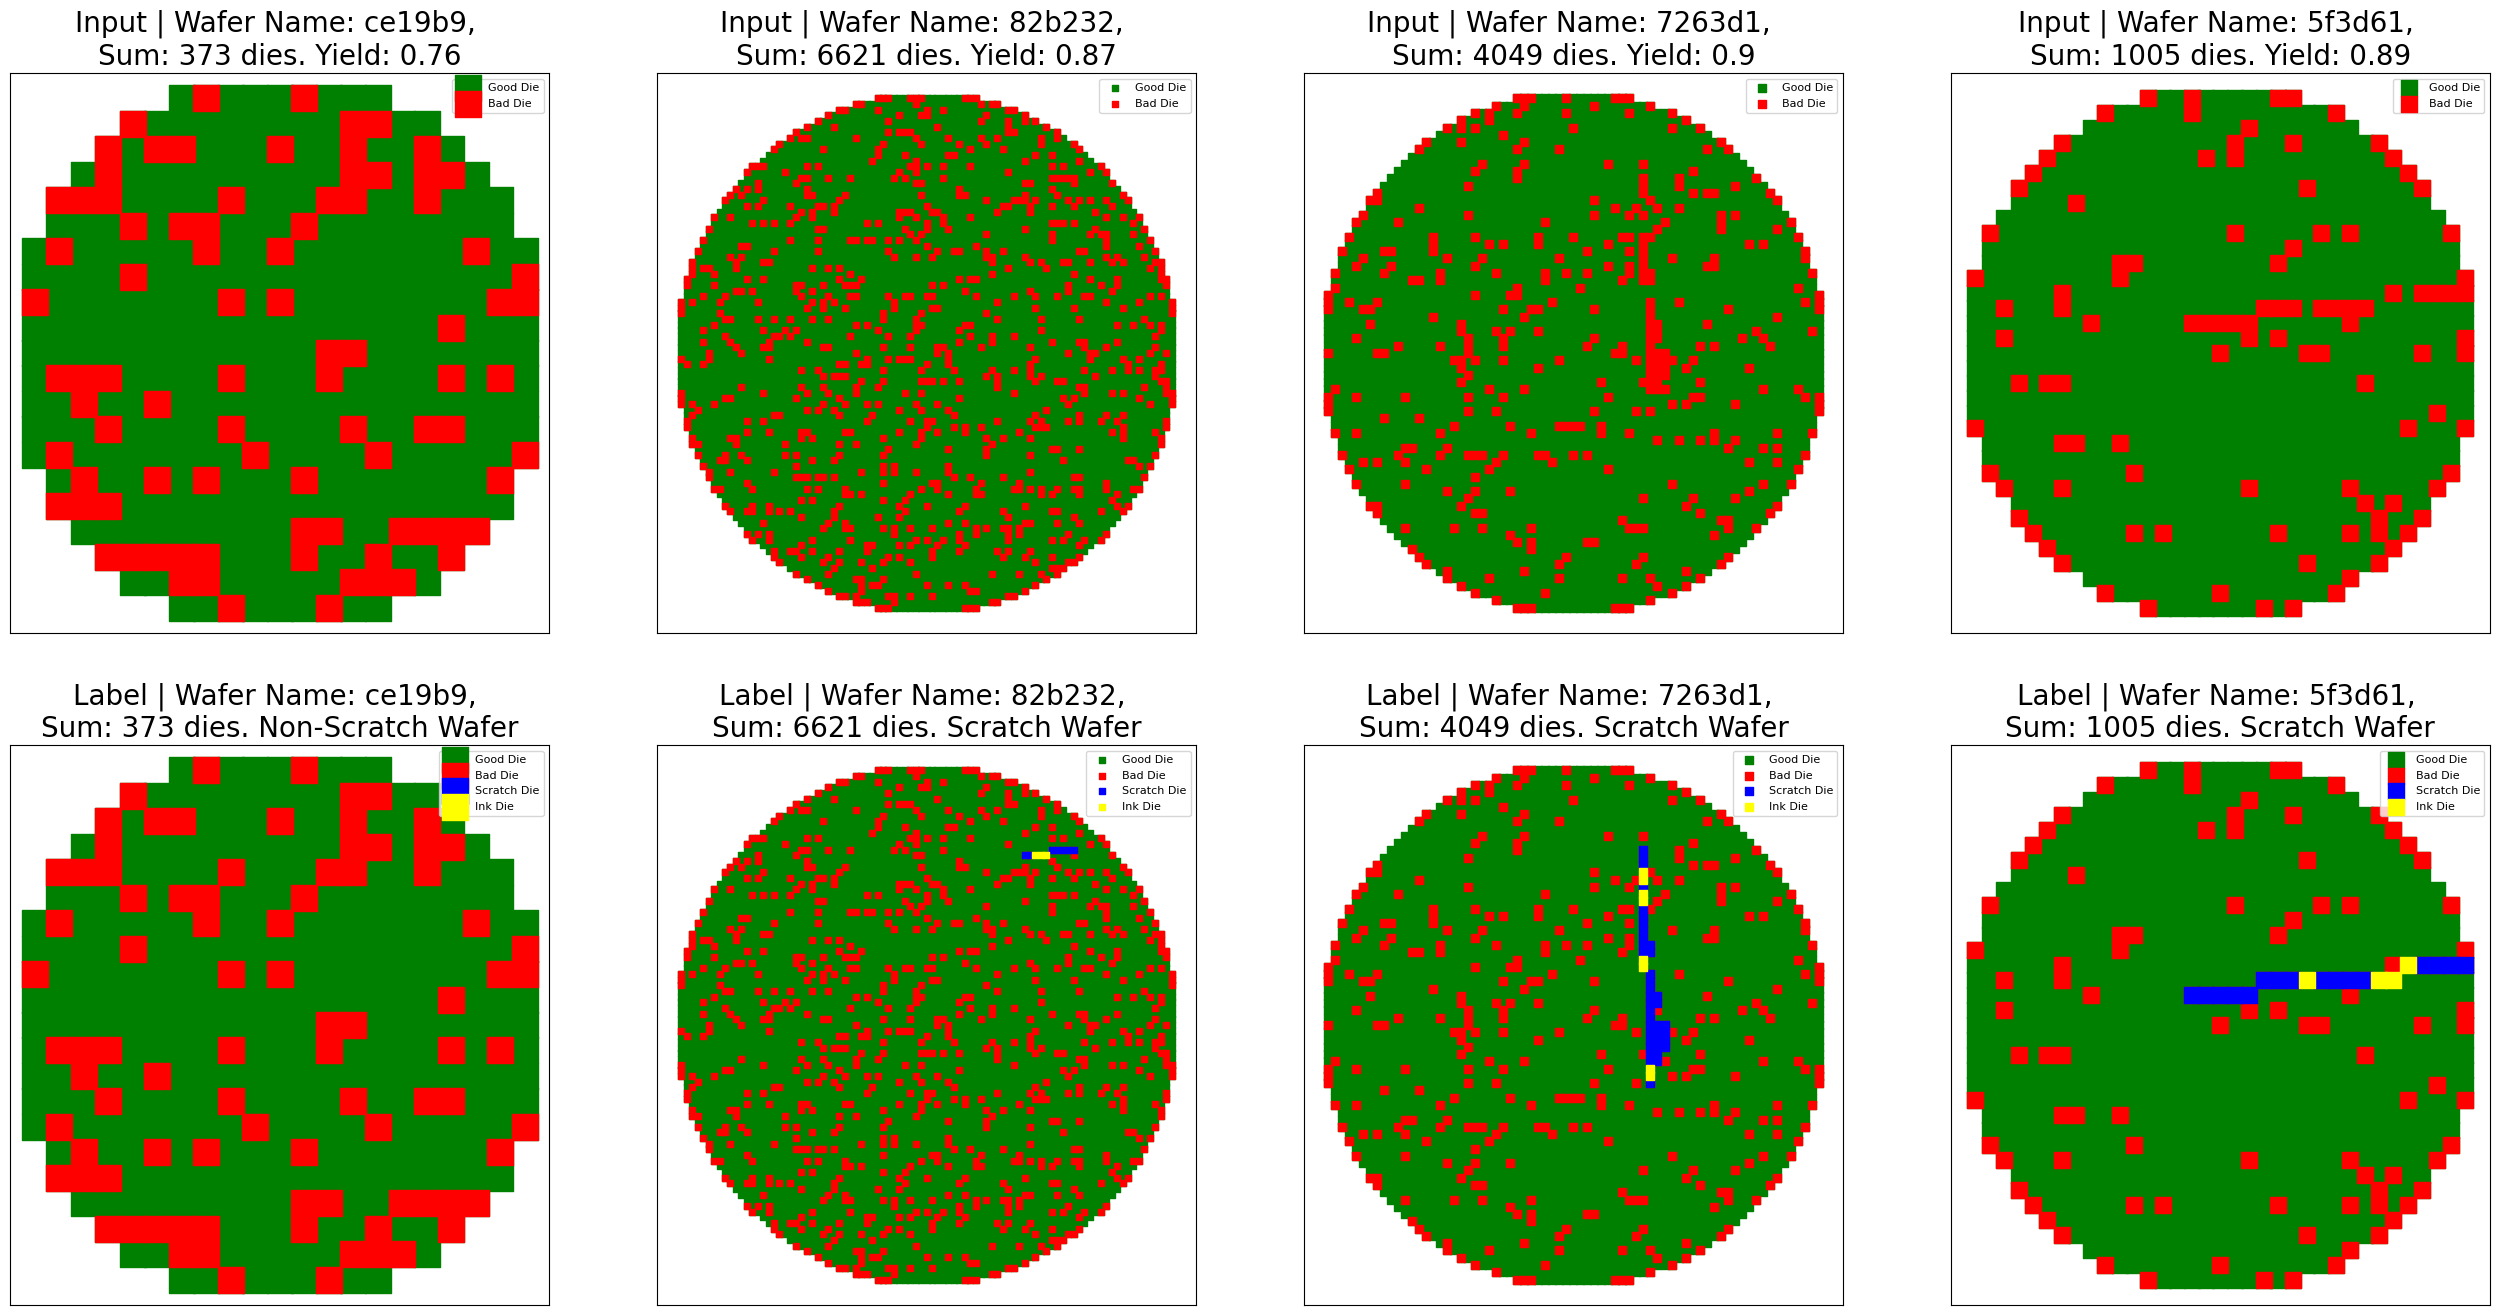

In [ ]:
n_samples = 4
list_sample_train = [df_wafers.groupby('WaferName').get_group(group) for group in df_wafers['WaferName'].value_counts().sample(n_samples).index]
plot_wafer_maps(list_sample_train, figsize = 8, labels = True)

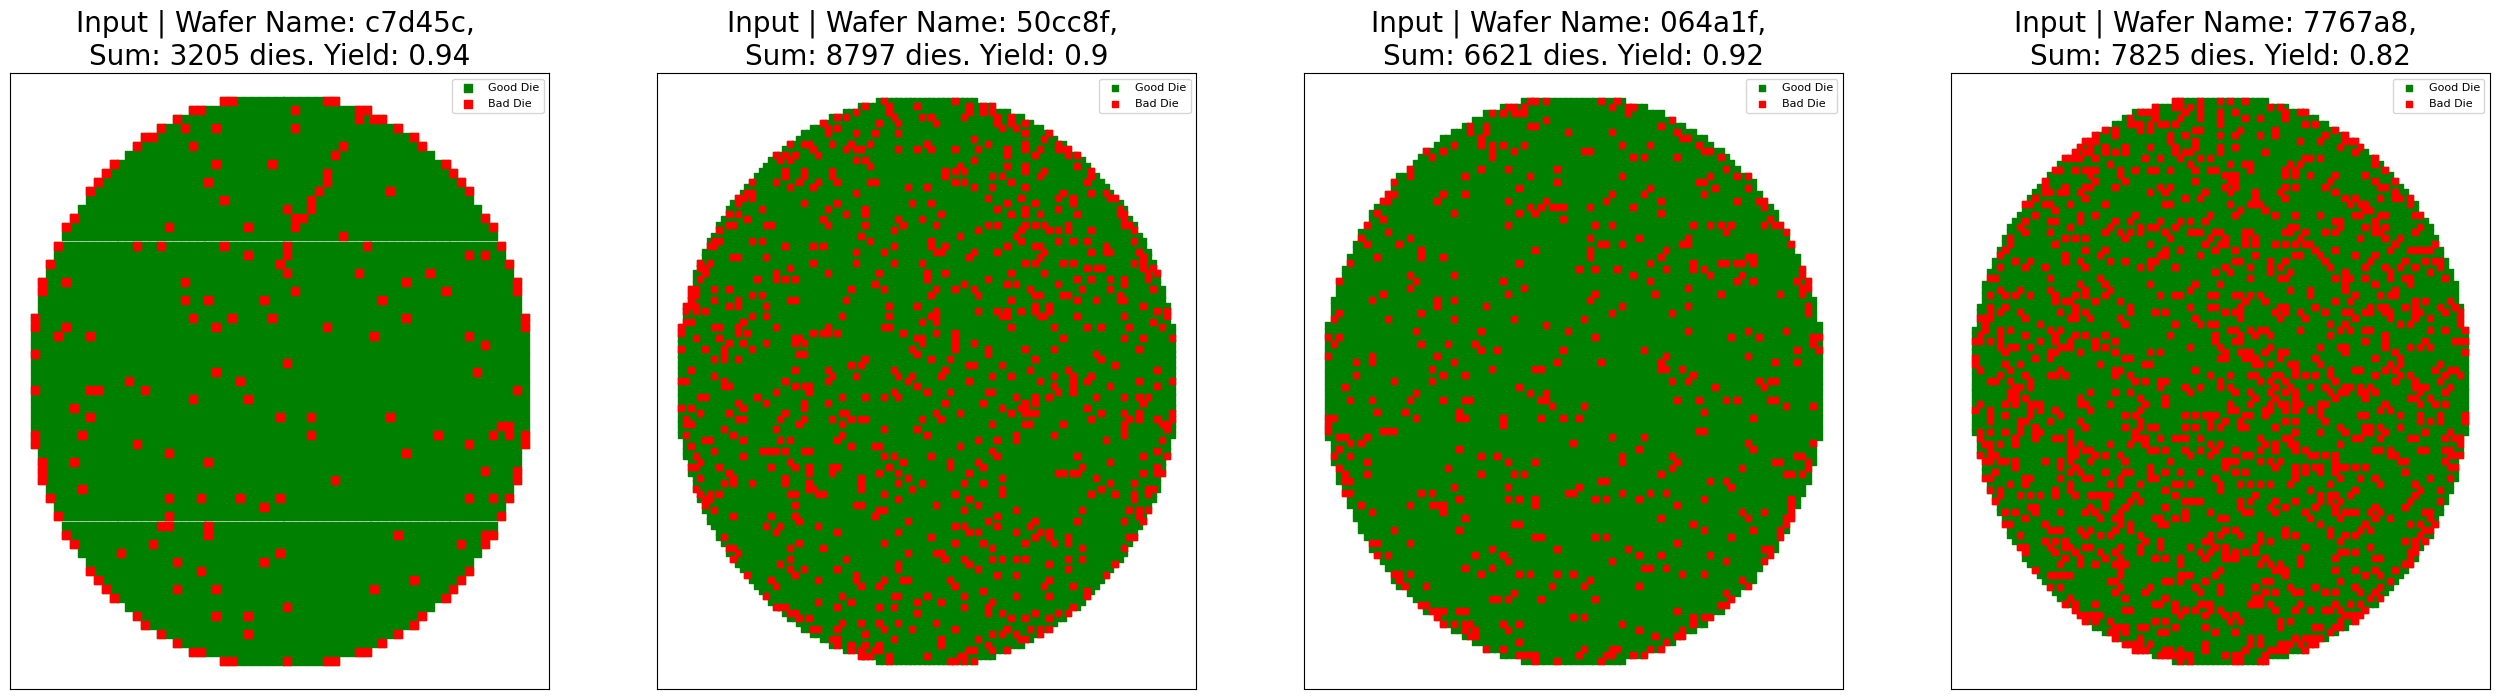

In [ ]:
list_sample_test = [df_wafers_test.groupby('WaferName').get_group(group) for group in df_wafers_test['WaferName'].value_counts().sample(n_samples).index]
plot_wafer_maps(list_sample_test, figsize = 8, labels = False)

# Build your solution

## Data Understanding

In [ ]:
# Summary of the "df_wafers" DataFrame
print(df_wafers.info())
print(" ")
# Display descriptive statistics
print(df_wafers.describe())

print(" ")
# Count of good and bad dies
print(df_wafers['IsGoodDie'].value_counts())

print(" ")
# Count of scratch and non-scratch dies
print(df_wafers['IsScratchDie'].value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16772092 entries, 0 to 16772091
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   WaferName     object
 1   DieX          int64 
 2   DieY          int64 
 3   IsGoodDie     int64 
 4   IsScratchDie  int64 
dtypes: int64(4), object(1)
memory usage: 767.8+ MB
None
 
               DieX          DieY     IsGoodDie  IsScratchDie
count  1.677209e+07  1.677209e+07  1.677209e+07  1.677209e+07
mean   4.136554e+01  4.136554e+01  8.944683e-01  4.694525e-03
std    2.373912e+01  2.373912e+01  3.072374e-01  6.835559e-02
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
25%    2.200000e+01  2.200000e+01  1.000000e+00  0.000000e+00
50%    3.900000e+01  3.900000e+01  1.000000e+00  0.000000e+00
75%    5.900000e+01  5.900000e+01  1.000000e+00  0.000000e+00
max    1.040000e+02  1.040000e+02  1.000000e+00  1.000000e+00
 
1    15002104
0     1769988
Name: IsGoodDie, dtype: int64
 
0    16693355
1       787

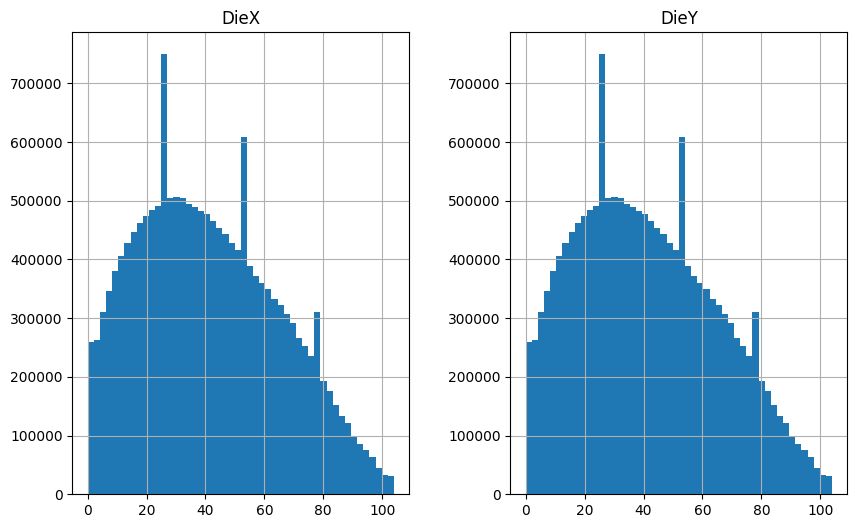

In [ ]:
# Histograms
df_wafers[['DieX', 'DieY']].hist(bins=50, figsize=(10,6))
plt.show()

## Data Preprocessing

In [ ]:
# Drop rows with missing values or duplicate
df_wafers.dropna(inplace=True)
df_wafers.drop_duplicates(inplace=True)

In [ ]:
# encode "IsScratchDie" and "IsScratchDie" to numerical values {False:0, True:1}
df_wafers['IsScratchDie'] = df_wafers['IsScratchDie'].astype(int)
df_wafers['IsGoodDie'] = df_wafers['IsGoodDie'].astype(int)
df_wafers.head()

,WaferName,DieX,DieY,IsGoodDie,IsScratchDie
0,3b2e28,0,12,0,0
1,3b2e28,0,13,1,0
2,3b2e28,0,14,0,0
3,3b2e28,0,15,1,0
4,3b2e28,0,16,1,0


When preparing the data, we will convert the tabular data into a matrix. 
Each wafer will be represented by a matrix of a size that corresponds to the 
actual wafer size, based on the available data. 
Each element in the matrix will be either 1 or 0, depending on the corresponding column in the original data. 
We will use -1 for padding.

In [ ]:
wafer_groups = df_wafers.groupby('WaferName')
wafer_names = df_wafers['WaferName'].unique()
df_wafers_lst = [wafer_groups.get_group(wafer) for wafer in wafer_names]


wafer_groups_test = df_wafers_test.groupby('WaferName')
wafer_names_test = df_wafers_test['WaferName'].unique()
df_wafers_lst_test = [wafer_groups_test.get_group(wafer) for wafer in wafer_names_test]

In [ ]:
def df_to_matrices(df, df_wafers_lst, test_df=False):
    unique_wafers = df['WaferName'].unique()
    wafer_matrices = {}

    if not test_df:
        wafer_label_matrices = {}

    for ind, df_wafer in enumerate(df_wafers_lst):
        max_dieX = df_wafer['DieX'].max()
        max_dieY = df_wafer['DieY'].max() 
        # wafer_matrix = np.zeros((max_dieX+1, max_dieY+1))
        wafer_matrix = np.full((max_dieX + 1, max_dieY + 1), -1)
        if not test_df:
            wafer_label_matrix = np.zeros((max_dieX+1, max_dieY+1))
        for _, row in df_wafer.iterrows():
            wafer_matrix[row['DieX']][row['DieY']] = row['IsGoodDie']
            if not test_df:
                wafer_label_matrix[row['DieX']][row['DieY']] = row['IsScratchDie']
        if not test_df:
            wafer_label_matrices[unique_wafers[ind]] = wafer_label_matrix
        wafer_matrices[unique_wafers[ind]] = wafer_matrix
    if not test_df:
        return wafer_matrices, wafer_label_matrices
    else:
        return wafer_matrices


wafer_matrices,wafer_label_matrices=df_to_matrices(df_wafers,df_wafers_lst)
wafer_matrices_test=df_to_matrices(df_wafers_test,df_wafers_lst_test, True)

In [ ]:
with open('wafer_data.pkl', 'wb') as f:
    pickle.dump((wafer_matrices,wafer_label_matrices), f)

In [ ]:
with open('wafer_data_test.pkl', 'wb') as f:
    pickle.dump((wafer_matrices_test), f)

In [ ]:
# load the variable 'data' from pickle file
with open("wafer_data.pkl", 'rb') as f:
    wafer_matrices,wafer_label_matrices = pickle.load(f)

with open("wafer_data_test.pkl", 'rb') as f:
    wafer_matrices_test = pickle.load(f)

## Modeling

Data Loader

In [ ]:
class WaferDataset(Dataset):
    def __init__(self, wafer_X,wafer_Y=None,is_test=False):
        self.X = wafer_X
        self.Y= wafer_Y
        self.is_test= is_test
        self.lst_name = list(wafer_X.keys())
    def __len__(self):
        return len(self.lst_name)
    
    def __getitem__(self, idx):
        if self.is_test:
            wafer_name = self.lst_name[idx]
            return wafer_name,torch.from_numpy(self.X[wafer_name]).unsqueeze(0).float()
        wafer_name = self.lst_name[idx]
        return torch.from_numpy(self.X[wafer_name]).unsqueeze(0).float(), torch.from_numpy(self.Y[wafer_name]).unsqueeze(0).float()


In [ ]:
wafer_dataset = WaferDataset(wafer_matrices,wafer_label_matrices)
wafer_dataset_test= WaferDataset(wafer_matrices_test, is_test=True)

#split the test to test and validation.
train_size = int(0.8 * len(wafer_dataset))  # 80% for training
val_size = len(wafer_dataset) - train_size  # 20% for validation

# Split the dataset
train_dataset, val_dataset = random_split(wafer_dataset, [train_size, val_size])

# Create DataLoaders for train and validation datasets
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(wafer_dataset_test, batch_size=1, shuffle=False)


### Model
This model is a Fully Convolutional Network (FCN) designed for predicting 'IsScratchDie' for each cell in a wafer.




1.   It consists of three Convolutional layers (Conv2d), each performing a matrix multiplication with learnable filters, useful for detecting patterns in the data.
2.   The first two layers are followed by ReLU activation functions introducing non-linearity, allowing the model to learn complex patterns.
3. A Dropout layer is used between the second and third Convolutional layers to prevent overfitting by randomly disabling 50% of neurons during training.
4. The last Convolutional layer is followed by a Sigmoid activation function for binary classification output.

In [ ]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(0.5)  # Dropout layer with p=0.5
        self.conv3 = nn.Conv2d(64, 1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.dropout(x)  # apply dropout
        x = torch.sigmoid(self.conv3(x))
        return x




*   nn.BCELoss(): Binary Cross Entropy (BCE) Loss is used for measuring the error in binary classification tasks.
*   torch.optim.Adam(model.parameters(), lr=0.001): Adam optimizer adjusts model's parameters based on gradients of the loss with learning rate lr=0.001.



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FCN().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

FCN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
)


In [ ]:
def train(train_loader,val_loader,epochs):
    train_losses=[]
    val_losses=[]
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # reset gradients
            outputs = model(inputs)  # forward pass
            loss = criterion(outputs, labels)  # calculate loss
            
            loss.backward()  # backward pass
            optimizer.step()  # update weights
            train_loss += loss.item()

        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                
        train_loss /= len(train_loader)
        valid_loss /= len(val_loader)
        val_losses.append(valid_loss)
        train_losses.append(train_loss)

        print(f"Epoch: {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}")

    # Plot the training and validation loss.
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()



Epoch: 1, Training Loss: 0.0245, Validation Loss: 0.0192
Epoch: 2, Training Loss: 0.0197, Validation Loss: 0.0170
Epoch: 3, Training Loss: 0.0184, Validation Loss: 0.0160
Epoch: 4, Training Loss: 0.0179, Validation Loss: 0.0157
Epoch: 5, Training Loss: 0.0176, Validation Loss: 0.0156
Epoch: 6, Training Loss: 0.0174, Validation Loss: 0.0153
Epoch: 7, Training Loss: 0.0171, Validation Loss: 0.0162
Epoch: 8, Training Loss: 0.0171, Validation Loss: 0.0175
Epoch: 9, Training Loss: 0.0170, Validation Loss: 0.0151
Epoch: 10, Training Loss: 0.0169, Validation Loss: 0.0162
Epoch: 11, Training Loss: 0.0169, Validation Loss: 0.0150
Epoch: 12, Training Loss: 0.0168, Validation Loss: 0.0152
Epoch: 13, Training Loss: 0.0167, Validation Loss: 0.0154
Epoch: 14, Training Loss: 0.0167, Validation Loss: 0.0150
Epoch: 15, Training Loss: 0.0167, Validation Loss: 0.0148
Epoch: 16, Training Loss: 0.0167, Validation Loss: 0.0149
Epoch: 17, Training Loss: 0.0166, Validation Loss: 0.0154
Epoch: 18, Training Los

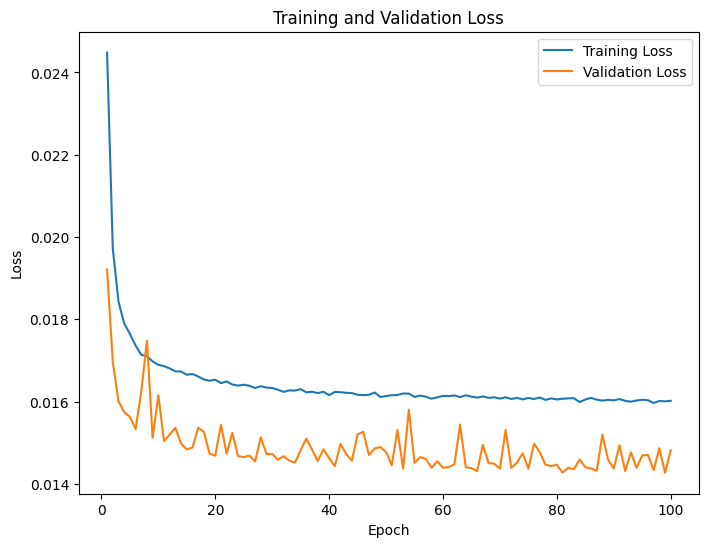

In [ ]:
train(train_loader,val_loader,epochs=100)

# Additional thoughts

Here you can detail about anything you want to mention as additional considerations for this solution, anything from ideas, thoughts, considerations about deployment or anything you may have raised when working on this task in a team.

In [ ]:
model.eval()  # Switch the model to evaluation mode
results = {}  # To store the model's predictions

with torch.no_grad():  
    for wafer_name,image in test_loader:
        image = image.to(device)  
        output = model(image)  
        predicted = torch.round(output)  # Round the output (0 or 1)
        results[wafer_name[0]]=predicted[0][0]  # Store the prediction
        



In [ ]:
IsScratchDie= []
for index, row in df_wafers_test.iterrows():
    name= row['WaferName']
    dieX = row['DieX']
    dieY = row['DieY']
    IsScratchDie.append(results[name][dieX][dieY].bool().cpu().numpy())

# Submission

In [ ]:
df_wafers_test['IsScratchDie'] = IsScratchDie
df_wafers_test.to_csv('df_wafers_test_with_preds.csv')